#Radius Of gyration branching and molar refractivity

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Descriptors3D

# --- 1. Define Calculation Functions ---

def calculate_polymer_properties(smiles_string):
    """
    Calculates Radius of Gyration, Molar Refractivity, and Branching Points
    for a given polymer SMILES string.
    """
    if not isinstance(smiles_string, str):
        return np.nan, np.nan, np.nan

    try:
        clean_smiles = smiles_string.replace('*', '')
        mol = Chem.MolFromSmiles(clean_smiles)
        if mol is None:
            return np.nan, np.nan, np.nan

        molar_refractivity = Descriptors.MolMR(mol)
        branching_points = sum(1 for atom in mol.GetAtoms() if atom.GetDegree() > 2)
        
        mol_h = Chem.AddHs(mol)
        if AllChem.EmbedMolecule(mol_h, randomSeed=42) == -1:
            radius_of_gyration = np.nan
        else:
            radius_of_gyration = Descriptors3D.RadiusOfGyration(mol_h)
            
        return radius_of_gyration, molar_refractivity, branching_points

    except Exception:
        return np.nan, np.nan, np.nan

def calculate_solvent_properties(smiles_string):
    """
    Calculates MolWt, MolMR, TPSA, H-Donors, and H-Acceptors for a solvent SMILES.
    """
    if not isinstance(smiles_string, str):
        return [np.nan] * 5

    try:
        mol = Chem.MolFromSmiles(smiles_string)
        if mol is None:
            return [np.nan] * 5

        mol_wt = Descriptors.MolWt(mol)
        mol_mr = Descriptors.MolMR(mol)
        tpsa = Descriptors.TPSA(mol)
        h_donors = Descriptors.NumHDonors(mol)
        h_acceptors = Descriptors.NumHAcceptors(mol)
        
        return [mol_wt, mol_mr, tpsa, h_donors, h_acceptors]
    except Exception:
        return [np.nan] * 5

# --- 2. Load Data and Define Solvent Properties ---
try:
    df = pd.read_csv("original.csv")

    dielectric_constants_map = {
        '1,1,1,2-tetrafluoroethane': 9.6, '1,1-difluoroethane': 10.9, '1,4-dioxane': 2.2,
        '1-butanol': 17.5, '1-chloro-1,1-difluoroethane': 7.4, '1-hexanol': 13.3,
        '1-hexene': 2.1, '1-pentanol': 15.1, '1-propanol': 20.3, '2-butanol': 17.9,
        '2-methylpropane': 1.8, '2-propanol': 19.9, 'r22': 6.1, 'acetone': 21.0,
        'argon': 1.5, 'benzene': 2.3, 'butyl acetate': 5.0, 'carbon dioxide': 1.6,
        'carbon monoxide': 1.6, 'carbon tetrachloride': 2.2, 'chlorine': 2.0,
        'chloroform': 4.8, 'cyclohexane': 2.0, 'cyclopentane': 2.0, 'di-n-propyl ether': 3.4,
        'dichloromethane': 9.1, 'diethyl ether': 4.3, 'diethyl ketone': 17.0,
        'dimethyl carbonate': 3.1, 'dimethyl methyl phosphonate': 20.6, 'dinitrogen monoxide': 1.6,
        'ethane': 1.9, 'ethanol': 24.5, 'ethene': 1.9, 'ethyl acetate': 6.0,
        'ethylbenzene': 2.4, 'helium': 1.05, 'hexafluoroethane': 2.0, 'hydrogen': 1.2,
        'hydrogen sulfide': 9.3, 'isobutanol': 17.9, 'isooctane, 2,2,4-trimethylpentane': 1.9,
        'isopentane': 1.8, 'krypton': 1.8, 'm-xylene': 2.4, 'methane': 1.7,
        'methanol': 33.0, 'methylacetate': 6.7, 'methylethylketone': 18.5,
        'n-butane': 1.8, 'n-heptane': 1.9, 'n-hexane': 1.9, 'n-pentane': 1.8,
        'neon': 1.1, 'neopentane': 1.8, 'nitrobenzene': 34.8, 'nitrogen': 1.4,
        'nitromethane': 35.9, 'nonane': 2.0, 'octafluoropropane': 2.0, 'octane': 2.0,
        'oxygen': 1.5, 'p-xylene': 2.3, 'propane': 1.6, 'propene': 2.1,
        'propylacetate': 5.6, 'sulfur hexafluoride': 1.8, 'sulphur dioxide': 15.6,
        'tert-butyl alcohol': 12.5, 'tetrafluoromethane': 1.6, 'tetrahydrofuran': 7.5,
        'toluene': 2.4, 'water': 80.1, 'xenon': 2.0
    }

    # --- 3. Apply Calculations and Create New Columns ---
    print("Calculating polymer and solvent properties... This may take a moment.")

    df['dielectric_constant'] = df['solvent_name'].str.lower().map(dielectric_constants_map)

    poly_props = df['polymer_smiles'].apply(lambda s: pd.Series(calculate_polymer_properties(s)))
    df[['radius_of_gyration', 'molar_refractivity', 'branching']] = poly_props

    solv_props = df['solvent_smiles'].apply(lambda s: pd.Series(calculate_solvent_properties(s)))
    df[['solvent_mol_wt', 'solvent_mol_mr', 'solvent_tpsa', 'solvent_h_donors', 'solvent_h_acceptors']] = solv_props

    # --- 4. Finalize and Save the DataFrame ---

    final_column_order = [
        'polymer_name', 'polymer_smiles', 'solvent_formula', 'solvent_name',
        'solvent_smiles', 'mn', 'mw', 'tg', 'dens', 'temperature',
        'dielectric_constant', 'molar_refractivity', 'radius_of_gyration',
        'branching', 'solvent_mol_wt', 'solvent_mol_mr', 'solvent_tpsa', 
        'solvent_h_donors', 'solvent_h_acceptors'
    ]

    final_df = df[final_column_order]
    final_df.to_csv('ok.csv', index=False)
    
    print("\n✅ Processing complete!")
    print("The new file 'final_augmented_dataset.csv' has been created with all properties.")
    print("\nPreview of the final data:")
    print(final_df.head())

except FileNotFoundError:
    print("Error: 'original.csv' not found. Please ensure it is in the same directory as the script.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Calculating polymer and solvent properties... This may take a moment.


[22:56:33] UFFTYPER: Unrecognized charge state for atom: 0
[22:56:33] UFFTYPER: Unrecognized charge state for atom: 0
[22:56:33] UFFTYPER: Unrecognized charge state for atom: 0
[22:56:33] UFFTYPER: Unrecognized charge state for atom: 0
[22:56:34] UFFTYPER: Unrecognized charge state for atom: 0
[22:56:34] UFFTYPER: Unrecognized charge state for atom: 0
[22:56:34] UFFTYPER: Unrecognized charge state for atom: 0
[22:56:34] UFFTYPER: Unrecognized charge state for atom: 0
[22:56:34] UFFTYPER: Unrecognized charge state for atom: 0
[22:56:34] UFFTYPER: Unrecognized charge state for atom: 0
[22:56:34] UFFTYPER: Unrecognized charge state for atom: 0
[22:56:34] UFFTYPER: Unrecognized charge state for atom: 0
[22:56:34] UFFTYPER: Unrecognized charge state for atom: 0



✅ Processing complete!
The new file 'final_augmented_dataset.csv' has been created with all properties.

Preview of the final data:
                                        polymer_name  \
0  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
1  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
2  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
3  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
4  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   

                                      polymer_smiles solvent_formula  \
0  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...          CH2Cl2   
1  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...          CH2Cl2   
2  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...          CH2Cl2   
3  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...             CO2   
4  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...             CO2   

      solvent_name solvent_smiles       mn     mw     tg   dens  temperature  \
0  dichloromethan

#Those whose values wre not available

In [ ]:
# import pandas as pd
# import numpy as np
# from rdkit import Chem
# from rdkit.Chem import AllChem, Descriptors, Descriptors3D
# import io

# # Suppress non-critical RDKit warnings
# from rdkit import rdBase
# rdBase.DisableLog('rdApp.warning')


# df = pd.read_csv('new.csv')

# # Lists to store the calculated values
# radii = []
# refractivities = []

# print("Processing polyelectrolytes...")
# # --- 2. Iterate and Calculate ---
# for index, row in df.iterrows():
#     name = row['Polyelectrolyte']
#     smiles = row['SMILES']
    
#     try:
#         if not isinstance(smiles, str):
#             raise ValueError("SMILES is not a string")

#         # Pre-processing for polymers and salts
#         if '.' in smiles:
#             smiles = max(smiles.split('.'), key=len)
#         smiles_clean = smiles.replace('*', '')

#         mol = Chem.MolFromSmiles(smiles_clean)
#         if mol is None:
#             raise ValueError("RDKit could not parse SMILES")

#         # Molar Refractivity (2D)
#         molar_refractivity = Descriptors.MolMR(mol)

#         # Radius of Gyration (3D)
#         mol_h = Chem.AddHs(mol)
#         if AllChem.EmbedMolecule(mol_h, randomSeed=42) == -1: # -1 indicates embedding failure
#              raise ValueError("3D embedding failed")
#         radius_gyration = Descriptors3D.RadiusOfGyration(mol_h)
        
#         # Append successful calculations
#         radii.append(radius_gyration)
#         refractivities.append(molar_refractivity)

#     except Exception as e:
#         # If any step fails, print an error and append NaN
#         print(f"  -> FAILED: '{name}'. Reason: {e}")
#         radii.append(np.nan)
#         refractivities.append(np.nan)

# # --- 3. Add New Columns to DataFrame ---
# df['Radius of gyration'] = radii
# df['Molar refractivity'] = refractivities

# print("\nProcessing complete!")
# print("\nHere's a preview of the final data:")
# print(df[['Polyelectrolyte', 'Radius of gyration', 'Molar refractivity']].head(10).round(3))

Processing polyelectrolytes...


[04:57:14] SMILES Parse Error: extra open parentheses while parsing: C(C)(C(=O)OCCCS(=O)(=O)[O-]
[04:57:14] SMILES Parse Error: check for mistakes around position 5:
[04:57:14] C(C)(C(=O)OCCCS(=O)(=O)[O-]
[04:57:14] ~~~~^
[04:57:14] SMILES Parse Error: Failed parsing SMILES 'C(C)(C(=O)OCCCS(=O)(=O)[O-]' for input: 'C(C)(C(=O)OCCCS(=O)(=O)[O-]'
[04:57:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[04:57:14] SMILES Parse Error: extra open parentheses while parsing: C(C)(C(=O)[O-]
[04:57:14] SMILES Parse Error: check for mistakes around position 5:
[04:57:14] C(C)(C(=O)[O-]
[04:57:14] ~~~~^
[04:57:14] SMILES Parse Error: Failed parsing SMILES 'C(C)(C(=O)[O-]' for input: 'C(C)(C(=O)[O-]'
[04:57:14] SMILES Parse Error: extra open parentheses while parsing: C(c1ccc(S(=O)(=O)[O-]
[04:57:14] SMILES Parse Error: check for mistakes around position 2:
[04:57:14] C(c1ccc(S(=O)(=O)[O-]
[04:57:14] ~^
[04:57:14] SMILES Parse Error: extra open parentheses while parsing: C(c1ccc(S(=

  -> FAILED: 'Poly(3-sulfopropyl methacrylate), potassium salt'. Reason: RDKit could not parse SMILES
  -> FAILED: 'Poly(ethylene glycol) diacrylate'. Reason: RDKit could not parse SMILES
  -> FAILED: 'Poly(sodium methacrylate)'. Reason: RDKit could not parse SMILES
  -> FAILED: 'Poly(sodium styrene sulfonate)'. Reason: RDKit could not parse SMILES


[04:57:15] SMILES Parse Error: syntax error while parsing: C(C)(C(=O)OCC[OP](=O)([O-])OCC[N+](C)(C)C)C
[04:57:15] SMILES Parse Error: check for mistakes around position 16:
[04:57:15] C(C)(C(=O)OCC[OP](=O)([O-])OCC[N+](C)(C)C
[04:57:15] ~~~~~~~~~~~~~~~^
[04:57:15] SMILES Parse Error: extra open parentheses while parsing: C(C)(C(=O)OCC[OP](=O)([O-])OCC[N+](C)(C)C)C
[04:57:15] SMILES Parse Error: check for mistakes around position 5:
[04:57:15] C(C)(C(=O)OCC[OP](=O)([O-])OCC[N+](C)(C)C
[04:57:15] ~~~~^
[04:57:15] SMILES Parse Error: Failed parsing SMILES 'C(C)(C(=O)OCC[OP](=O)([O-])OCC[N+](C)(C)C)C' for input: 'C(C)(C(=O)OCC[OP](=O)([O-])OCC[N+](C)(C)C)C'
[04:57:15] SMILES Parse Error: extra open parentheses while parsing: C(C(=O)[O-]
[04:57:15] SMILES Parse Error: check for mistakes around position 2:
[04:57:15] C(C(=O)[O-]
[04:57:15] ~^
[04:57:15] SMILES Parse Error: Failed parsing SMILES 'C(C(=O)[O-]' for input: 'C(C(=O)[O-]'
[04:57:15] SMILES Parse Error: extra open parentheses while

  -> FAILED: 'Poly(2-(methacryloyloxy)ethyl phosphorylcholine)'. Reason: RDKit could not parse SMILES
  -> FAILED: 'Poly(acrylic acid), lithium salt'. Reason: RDKit could not parse SMILES
  -> FAILED: 'Poly(acrylic acid), potassium salt'. Reason: RDKit could not parse SMILES
  -> FAILED: 'Poly(N-vinylimidazole)'. Reason: RDKit could not parse SMILES
  -> FAILED: 'Poly(sodium 4-vinylbenzenesulfonate)'. Reason: RDKit could not parse SMILES


[04:57:15] SMILES Parse Error: extra open parentheses while parsing: C(c1ccc(S(=O)(=O)[O-]
[04:57:15] SMILES Parse Error: check for mistakes around position 2:
[04:57:15] C(c1ccc(S(=O)(=O)[O-]
[04:57:15] ~^
[04:57:15] SMILES Parse Error: extra open parentheses while parsing: C(c1ccc(S(=O)(=O)[O-]
[04:57:15] SMILES Parse Error: check for mistakes around position 8:
[04:57:15] C(c1ccc(S(=O)(=O)[O-]
[04:57:15] ~~~~~~~^
[04:57:15] SMILES Parse Error: Failed parsing SMILES 'C(c1ccc(S(=O)(=O)[O-]' for input: 'C(c1ccc(S(=O)(=O)[O-]'
[04:57:15] SMILES Parse Error: extra open parentheses while parsing: C(C)(C(=O)[O-]
[04:57:15] SMILES Parse Error: check for mistakes around position 5:
[04:57:15] C(C)(C(=O)[O-]
[04:57:15] ~~~~^
[04:57:15] SMILES Parse Error: Failed parsing SMILES 'C(C)(C(=O)[O-]' for input: 'C(C)(C(=O)[O-]'
[04:57:15] SMILES Parse Error: extra open parentheses while parsing: C(C)(C(=O)[O-]
[04:57:15] SMILES Parse Error: check for mistakes around position 5:
[04:57:15] C(C)(C(=O)

  -> FAILED: 'Poly(styrene sulfonic acid), potassium salt'. Reason: RDKit could not parse SMILES
  -> FAILED: 'Poly(methacrylic acid, potassium salt)'. Reason: RDKit could not parse SMILES
  -> FAILED: 'Poly(methacrylic acid, lithium salt)'. Reason: RDKit could not parse SMILES
  -> FAILED: 'Dextran sulfate sodium salt'. Reason: RDKit could not parse SMILES
  -> FAILED: 'Poly(vinyl sulfate), potassium salt'. Reason: RDKit could not parse SMILES
  -> FAILED: 'Sulfated hyaluronic acid'. Reason: RDKit could not parse SMILES
  -> FAILED: 'Sulfated dextran'. Reason: RDKit could not parse SMILES

Processing complete!

Here's a preview of the final data:
           Polyelectrolyte  Radius of gyration  Molar refractivity
0        Cellulose acetate               2.782              45.693
1        Cellulose nitrate               2.972              46.137
2                 Chitosan               2.234              36.565
3          Ethyl cellulose               2.741              49.683
4        

[04:57:16] SMILES Parse Error: unclosed ring for input: 'O3S(=O)(=O)OC(=O)C1C(O)C(O)OC(CO)C1O'
[04:57:16] SMILES Parse Error: unclosed ring for input: 'O3S(=O)(=O)OC1C(O)C(O)OC(CO)C1O'


#Filtering the Augmnent1

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors3D
import numpy as np

def calculate_radius_of_gyration(smiles_string):
    
    if not isinstance(smiles_string, str):
        return np.nan

    try:
        # For polymers represented by their repeating unit, remove the '*'
        clean_smiles = smiles_string.replace('*', '')

        # Create a molecule object from the SMILES string
        mol = Chem.MolFromSmiles(clean_smiles)
        if mol is None:
            return np.nan

        # Add hydrogens, which are essential for creating a realistic 3D structure
        mol_with_hs = Chem.AddHs(mol)

        # Generate a 3D conformation of the molecule
        # The function will return -1 if embedding fails
        if AllChem.EmbedMolecule(mol_with_hs, randomSeed=42) == -1:
            return np.nan

        # Calculate the Radius of Gyration from the 3D structure
        radius_of_gyration = Descriptors3D.RadiusOfGyration(mol_with_hs)
        return radius_of_gyration

    except Exception:
        return np.nan

# --- Main script ---
if __name__ == "__main__":
    try:
        # 1. Read the data from your CSV file
        df = pd.read_csv('augment_rog.csv')

        # 2. Calculate the Radius of Gyration for each polymer
        #    The .apply() method will execute the function for each SMILES string
        print("Calculating Radius of Gyration for each polymer...")
        df['radius_of_gyration'] = df['polymer_smiles'].apply(calculate_radius_of_gyration)
        print("Calculation complete.")

        # 3. Save the updated DataFrame to a new CSV file
        output_filename = 'augment-_final.csv'
        df.to_csv(output_filename, index=False)

        print(f"\nSuccessfully created '{output_filename}' with the new 'radius_of_gyration' column.")
        print("\nHere's a preview of the updated data:")
        print(df[['polymer_name', 'polymer_smiles', 'radius_of_gyration']].head())

    except FileNotFoundError:
        print("Error: 'data.csv' not found. Please ensure the file is in the same directory as the script.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Calculating Radius of Gyration for each polymer...


[01:33:20] UFFTYPER: Unrecognized charge state for atom: 0
[01:33:20] UFFTYPER: Unrecognized charge state for atom: 0
[01:33:20] UFFTYPER: Unrecognized charge state for atom: 0
[01:33:20] UFFTYPER: Unrecognized charge state for atom: 0
[01:33:20] UFFTYPER: Unrecognized charge state for atom: 0
[01:33:20] UFFTYPER: Unrecognized charge state for atom: 0
[01:33:20] UFFTYPER: Unrecognized charge state for atom: 0
[01:33:20] UFFTYPER: Unrecognized charge state for atom: 0
[01:33:20] UFFTYPER: Unrecognized charge state for atom: 0
[01:33:20] UFFTYPER: Unrecognized charge state for atom: 0
[01:33:20] UFFTYPER: Unrecognized charge state for atom: 0
[01:33:20] UFFTYPER: Unrecognized charge state for atom: 0
[01:33:20] UFFTYPER: Unrecognized charge state for atom: 0


KeyboardInterrupt: Embedding cancelled

In [ ]:
import pandas as pd
from rdkit import Chem
import numpy as np
import io

def calculate_branching_points(smiles_string):
    """
    Calculates the number of branching points in a molecule.

    A branching point is defined as an atom with a degree of 3 or higher
    (i.e., connected to 3 or more other non-hydrogen atoms).
    Returns an integer count.
    """
    if not isinstance(smiles_string, str):
        return np.nan

    try:
        # Clean the SMILES string for polymer repeating units
        clean_smiles = smiles_string.replace('*', '')

        mol = Chem.MolFromSmiles(clean_smiles)
        if mol is None:
            return 0 # Return 0 if SMILES is invalid

        branching_count = 0
        for atom in mol.GetAtoms():
            # GetDegree() counts the number of explicit bonds to other atoms
            if atom.GetDegree() > 2:
                branching_count += 1
        return branching_count

    except Exception:
        return 0

# --- Main script ---
if __name__ == "__main__":
    
    df = pd.read_csv('augment_rog.csv')


    # Calculate the integer branching count for each polymer
    print("Calculating branching points for each polymer...")
    df['branching_points'] = df['polymer_smiles'].apply(calculate_branching_points)
    print("Calculation complete.")

    # Save the updated DataFrame to a new CSV file
    output_filename = 'data_with_branching.csv'
    df.to_csv(output_filename, index=False)

    print(f"\nSuccessfully created '{output_filename}' with the new 'branching_points' column.")
    print("\nHere's a preview of the updated data:")
    print(df[['polymer_name', 'polymer_smiles', 'branching_points']].head())

Calculating branching points for each polymer...
Calculation complete.

Successfully created 'data_with_branching.csv' with the new 'branching_points' column.

Here's a preview of the updated data:
                                        polymer_name  \
0  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
1  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
2  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
3  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
4  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   

                                      polymer_smiles  branching_points  
0  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...                18  
1  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...                18  
2  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...                18  
3  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...                18  
4  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...                18  


--- Analysis 1: Tg Dependence on Solvent Polarity ---


/tmp/ipykernel_37896/3520000285.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


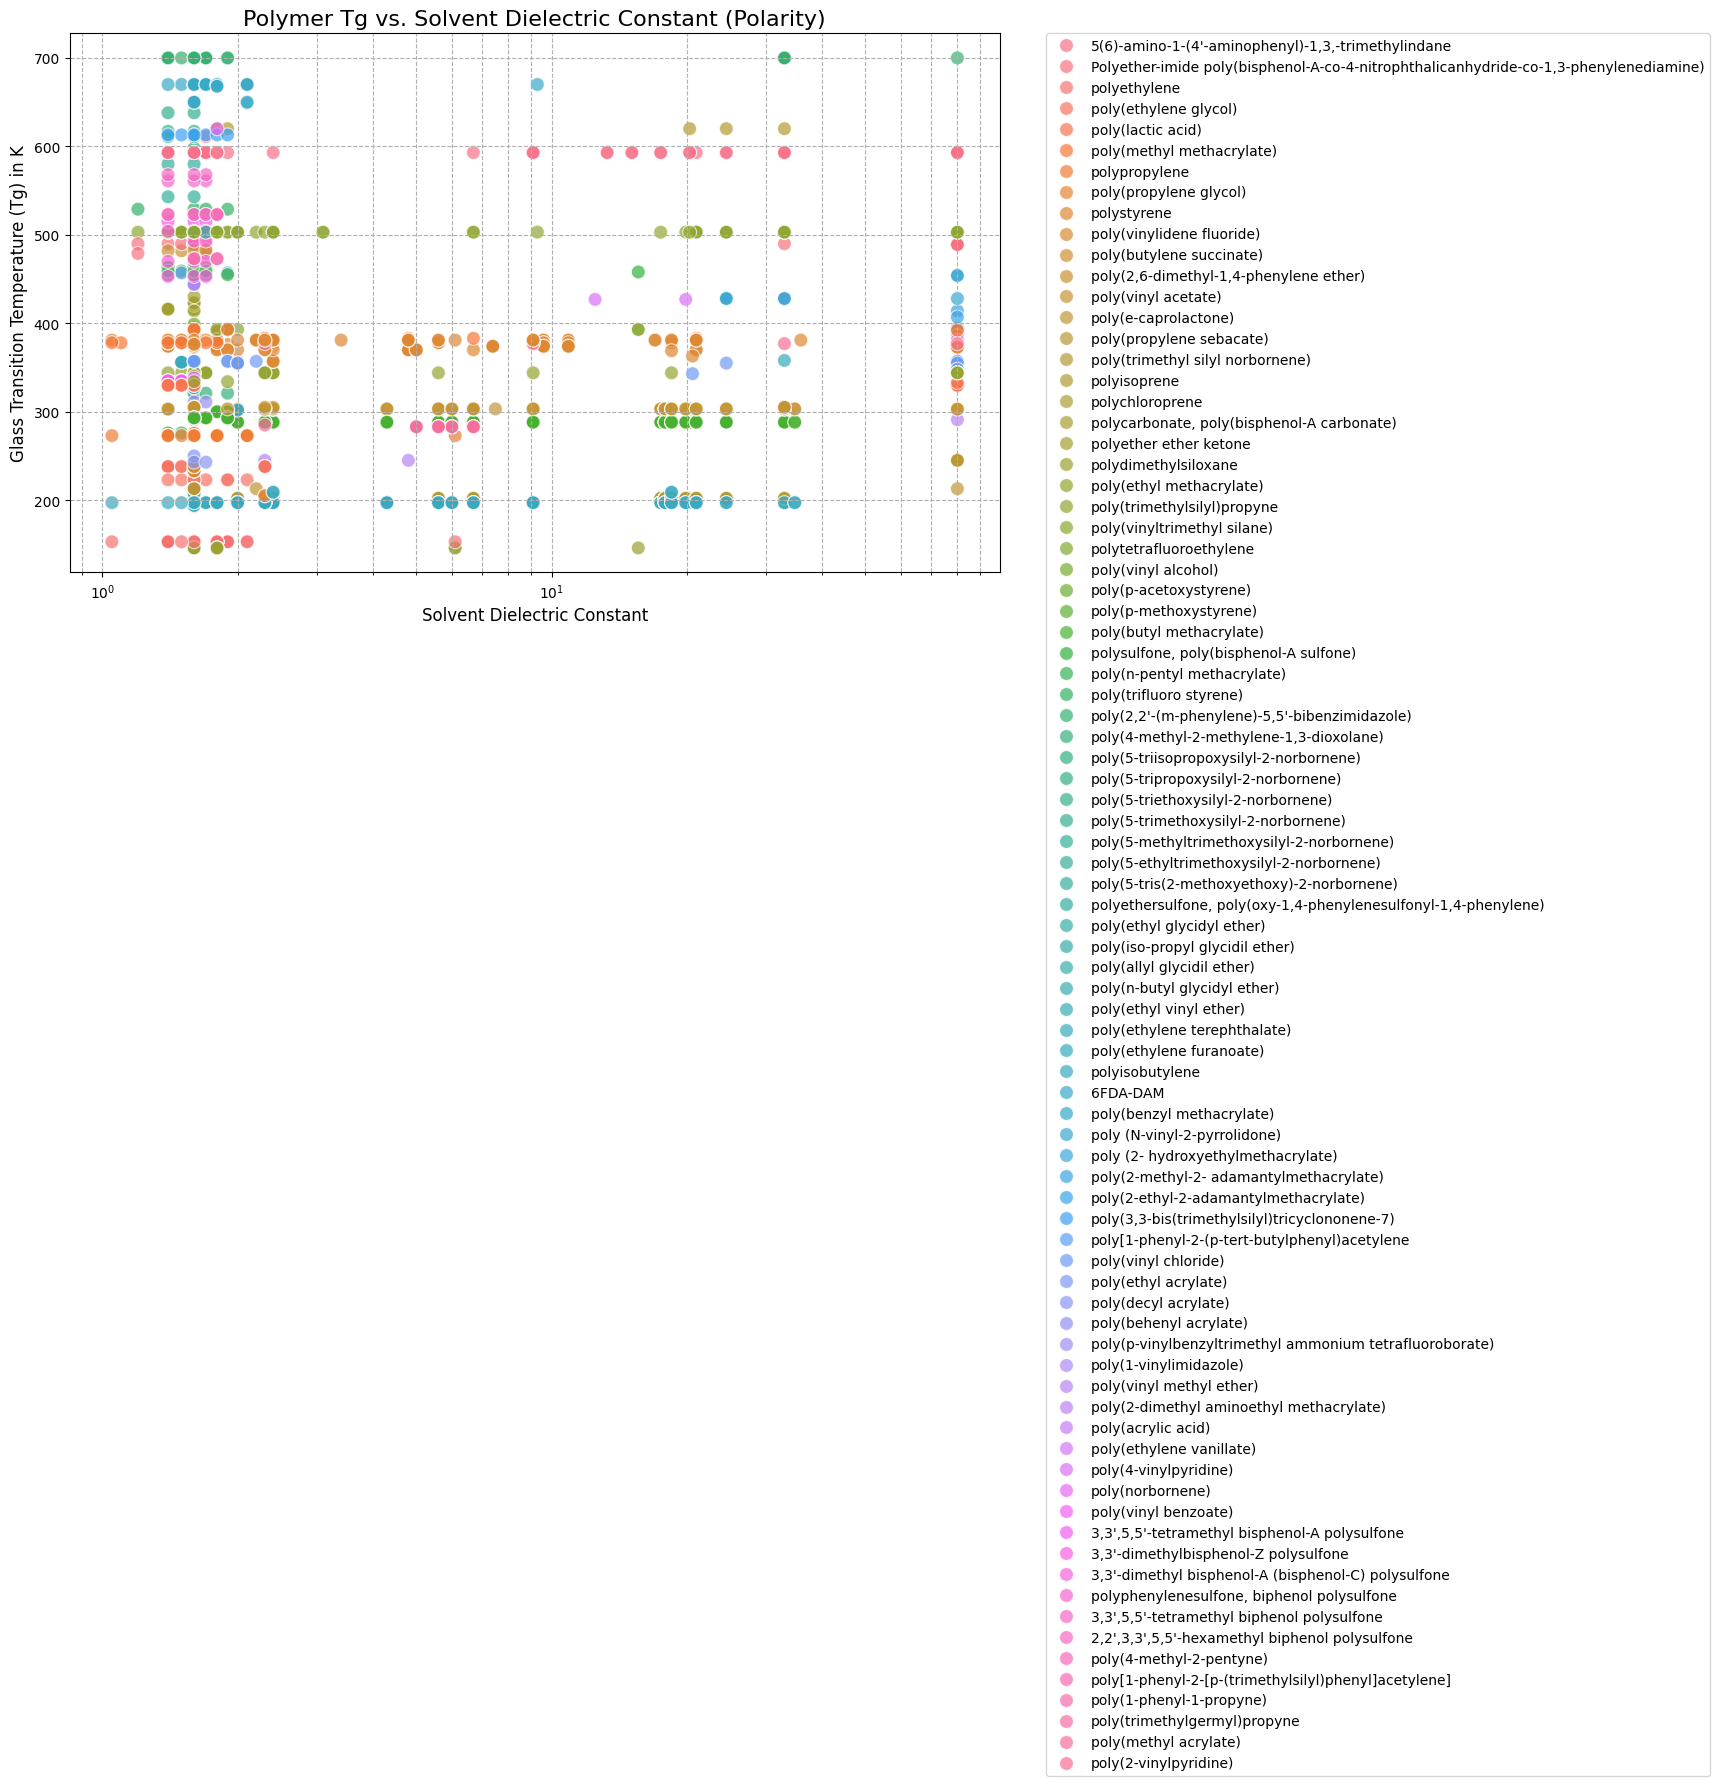

Insight: The plot 'tg_vs_polarity.png' has been generated.
Generally, for a given polymer, Tg can be depressed by small molecule solvents.
Highly polar solvents (high dielectric constant) may interact more strongly with polar polymers, potentially plasticizing them and lowering Tg.
Gases like CO2 and N2 (low dielectric constant) can also lower Tg, a phenomenon known as gas plasticization.

--- Analysis 2: Correlation Matrix and Feature Importance ---


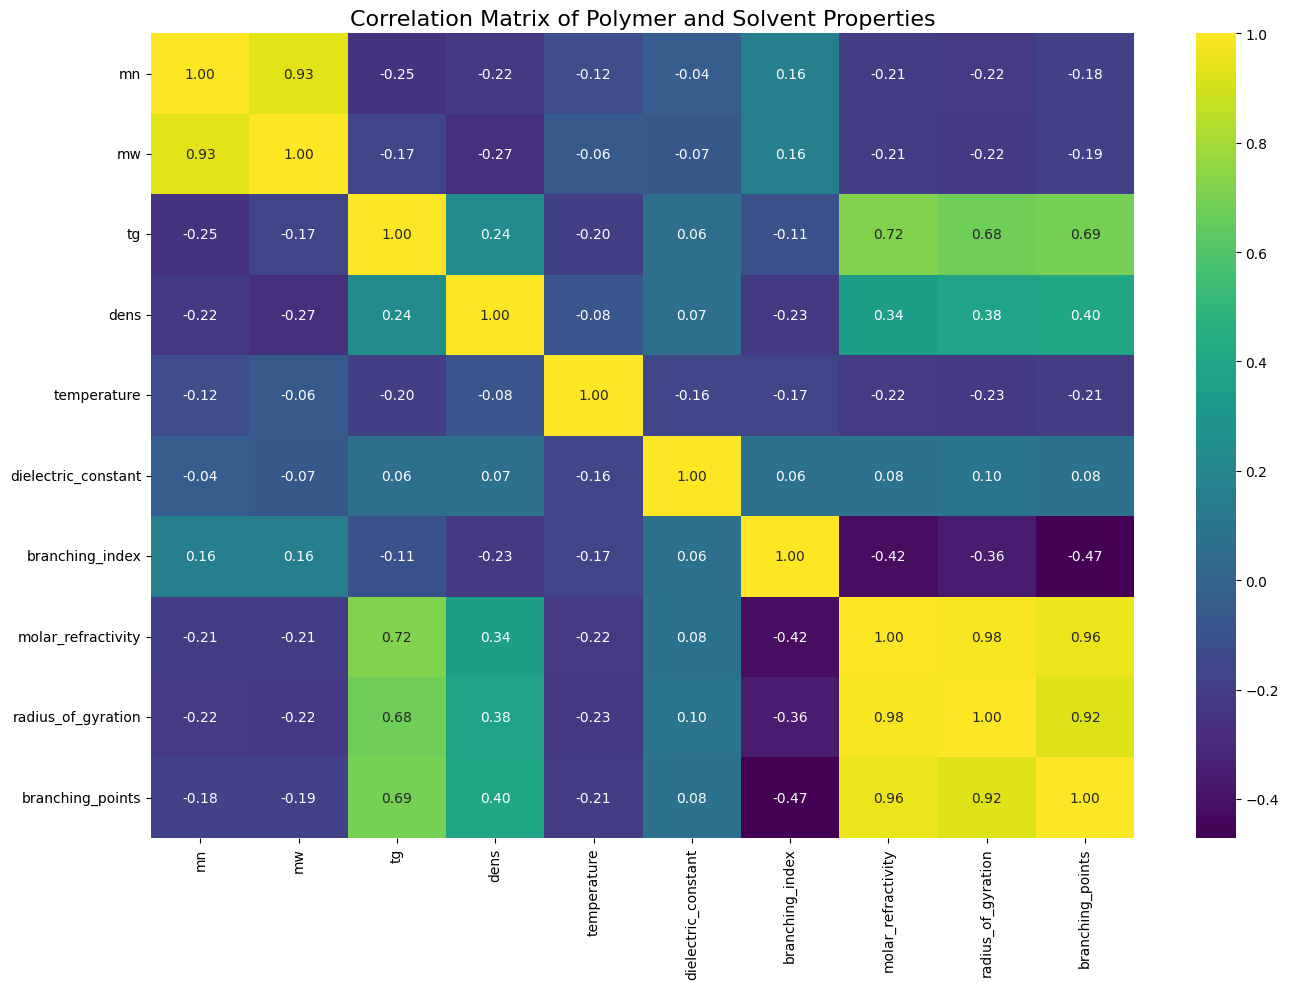

Insight: The plot 'correlation_matrix.png' shows the correlation between all numerical features.

Features correlated with Tg:
tg                     1.000000
molar_refractivity     0.722938
branching_points       0.690979
radius_of_gyration     0.675760
dens                   0.238416
dielectric_constant    0.057495
branching_index       -0.107204
mw                    -0.168646
temperature           -0.199229
mn                    -0.253116
Name: tg, dtype: float64

Key Observations:
- Polymer properties like 'molar_refractivity', 'radius_of_gyration', and 'branching_points' show a strong positive correlation with Tg. This is expected, as larger, more complex monomers create less flexible polymers with higher Tgs.
- 'mn' and 'mw' (molecular weights) also show a positive correlation, aligning with the Flory-Fox theory.
- Solvent 'dielectric_constant' shows a weaker correlation in this overall view because its effect is specific to each polymer.

--- Analysis 3: Dominant Factor Analysi

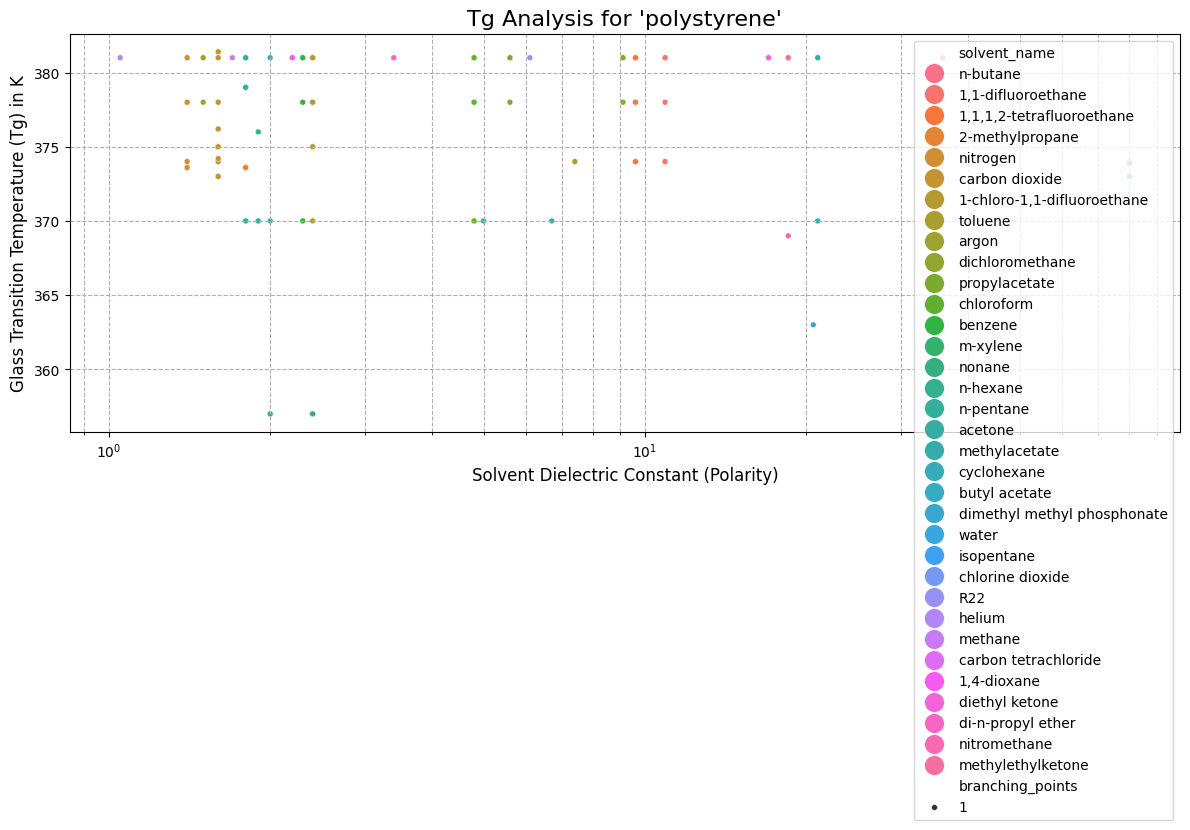

Insight: The plot 'dominant_factor_analysis.png' has been generated for 'polystyrene'.
For a single polymer (where branching is constant), the change in Tg is primarily driven by the solvent's plasticizing effect.
When comparing DIFFERENT polymers, branching and monomer structure are the dominant factors determining the baseline Tg.
The solvent then modifies this baseline Tg. Therefore, polymer structure (like branching) is the primary factor, and solvent interaction is the secondary, modifying factor.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import numpy as np

# --- Main Analysis Script ---
if __name__ == "__main__":
    
    df = pd.read_csv('data_with_branching.csv')

    # --- 1. Analysis of Tg vs. Solvent Polarity ---
    print("--- Analysis 1: Tg Dependence on Solvent Polarity ---")

    # The dielectric constant is a good proxy for polarity
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df, x='dielectric_constant', y='tg', hue='polymer_name', s=100, alpha=0.7)
    plt.title('Polymer Tg vs. Solvent Dielectric Constant (Polarity)', fontsize=16)
    plt.xlabel('Solvent Dielectric Constant', fontsize=12)
    plt.ylabel('Glass Transition Temperature (Tg) in K', fontsize=12)
    plt.xscale('log') # Use a log scale for better visualization of wide-ranging constants
    plt.grid(True, which="both", ls="--")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig('tg_vs_polarity.png')
    plt.show()

    print("Insight: The plot 'tg_vs_polarity.png' has been generated.")
    print("Generally, for a given polymer, Tg can be depressed by small molecule solvents.")
    print("Highly polar solvents (high dielectric constant) may interact more strongly with polar polymers, potentially plasticizing them and lowering Tg.")
    print("Gases like CO2 and N2 (low dielectric constant) can also lower Tg, a phenomenon known as gas plasticization.\n")


    # --- 2. Correlation Matrix and Feature Analysis ---
    print("--- Analysis 2: Correlation Matrix and Feature Importance ---")

    # Select only the numerical columns for correlation analysis
    numerical_df = df.select_dtypes(include=np.number)

    plt.figure(figsize=(14, 10))
    correlation_matrix = numerical_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Correlation Matrix of Polymer and Solvent Properties', fontsize=16)
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    plt.show()

    print("Insight: The plot 'correlation_matrix.png' shows the correlation between all numerical features.")

    # Analyze the correlation of all features with Tg
    tg_correlation = correlation_matrix['tg'].sort_values(ascending=False)
    print("\nFeatures correlated with Tg:")
    print(tg_correlation)

    print("\nKey Observations:")
    print("- Polymer properties like 'molar_refractivity', 'radius_of_gyration', and 'branching_points' show a strong positive correlation with Tg. This is expected, as larger, more complex monomers create less flexible polymers with higher Tgs.")
    print("- 'mn' and 'mw' (molecular weights) also show a positive correlation, aligning with the Flory-Fox theory.")
    print("- Solvent 'dielectric_constant' shows a weaker correlation in this overall view because its effect is specific to each polymer.\n")


    # --- 3. Dominant Factor Analysis: Polarity vs. Branching ---
    print("--- Analysis 3: Dominant Factor Analysis (Polarity vs. Branching) ---")
    # To analyze this, we can look at a specific polymer across different solvents
    
    # Filter for a polymer that exists in multiple solvent types if possible
    example_polymer_name = df['polymer_name'].value_counts().idxmax()
    subset_df = df[df['polymer_name'] == example_polymer_name]

    if len(subset_df) > 1:
        plt.figure(figsize=(12, 7))
        sns.scatterplot(data=subset_df, x='dielectric_constant', y='tg', size='branching_points', hue='solvent_name', s=200)
        plt.title(f"Tg Analysis for '{example_polymer_name}'", fontsize=16)
        plt.xlabel('Solvent Dielectric Constant (Polarity)', fontsize=12)
        plt.ylabel('Glass Transition Temperature (Tg) in K', fontsize=12)
        plt.xscale('log')
        plt.grid(True, which="both", ls="--")
        plt.tight_layout()
        plt.savefig('dominant_factor_analysis.png')
        plt.show()
        
        print(f"Insight: The plot 'dominant_factor_analysis.png' has been generated for '{example_polymer_name}'.")
        print("For a single polymer (where branching is constant), the change in Tg is primarily driven by the solvent's plasticizing effect.")
        print("When comparing DIFFERENT polymers, branching and monomer structure are the dominant factors determining the baseline Tg.")
        print("The solvent then modifies this baseline Tg. Therefore, polymer structure (like branching) is the primary factor, and solvent interaction is the secondary, modifying factor.")
    else:
        print("Could not perform dominant factor analysis: not enough data for a single polymer across different solvents in the sample.")

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors

def calculate_solvent_properties(smiles_string):
    """
    Calculates a suite of descriptors for a given solvent SMILES string.
    """
    if not isinstance(smiles_string, str):
        return [np.nan] * 5  # Return NaNs for all 5 new columns if input is invalid

    try:
        mol = Chem.MolFromSmiles(smiles_string)
        if mol is None:
            return [np.nan] * 5

        mol_wt = Descriptors.MolWt(mol)
        mol_mr = Descriptors.MolMR(mol)
        tpsa = Descriptors.TPSA(mol)
        h_donors = Descriptors.NumHDonors(mol)
        h_acceptors = Descriptors.NumHAcceptors(mol)

        return [mol_wt, mol_mr, tpsa, h_donors, h_acceptors]
    except Exception:
        return [np.nan] * 5

# --- Main Data Augmentation Script ---
if __name__ == "__main__":
    try:
        # 1. Load your dataset
        # This assumes you have a file named 'data_with_branching.csv'
        df = pd.read_csv('data_with_branching.csv')

        # 2. Augment the dataset with new solvent features
        print("Calculating new solvent descriptors...")
        new_cols = ['solvent_mol_wt', 'solvent_mol_mr', 'solvent_tpsa', 'solvent_h_donors', 'solvent_h_acceptors']
        df[new_cols] = df['solvent_smiles'].apply(lambda s: pd.Series(calculate_solvent_properties(s)))
        print("Dataset augmented successfully.")

        # 3. Save the new, richer dataset
        output_filename = 'data_augmented.csv'
        df.to_csv(output_filename, index=False)
        
        print(f"\n✅ Successfully produced the augmented dataset.")
        print(f"The new file is saved as: '{output_filename}'")

        print("\nHere's a preview of the new columns in the dataset:")
        print(df[['solvent_name', 'solvent_smiles'] + new_cols].head())

    except FileNotFoundError:
        print("Error: 'data_with_branching.csv' not found. Please ensure the file is in the same directory.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Calculating new solvent descriptors...


Dataset augmented successfully.

✅ Successfully produced the augmented dataset.
The new file is saved as: 'data_augmented.csv'

Here's a preview of the new columns in the dataset:
      solvent_name solvent_smiles  solvent_mol_wt  solvent_mol_mr  \
0  dichloromethane          ClCCl          84.933          16.573   
1  dichloromethane          ClCCl          84.933          16.573   
2  dichloromethane          ClCCl          84.933          16.573   
3   carbon dioxide          O=C=O          44.009           5.007   
4   carbon dioxide          O=C=O          44.009           5.007   

   solvent_tpsa  solvent_h_donors  solvent_h_acceptors  
0          0.00               0.0                  0.0  
1          0.00               0.0                  0.0  
2          0.00               0.0                  0.0  
3         34.14               0.0                  2.0  
4         34.14               0.0                  2.0  


Successfully loaded 'data_augmented.csv'.
Generating new correlation matrix with augmented features...

✅ Correlation matrix saved as 'augmented_correlation_matrix.png'.

--- Features correlated with Tg (from augmented dataset) ---
tg                     1.000000
molar_refractivity     0.722938
branching_points       0.690979
radius_of_gyration     0.675760
dens                   0.238416
solvent_tpsa           0.089168
dielectric_constant    0.057495
solvent_h_acceptors    0.018232
solvent_h_donors      -0.044639
branching_index       -0.107204
mw                    -0.168646
temperature           -0.199229
mn                    -0.253116
solvent_mol_mr        -0.262747
solvent_mol_wt        -0.266418
Name: tg, dtype: float64


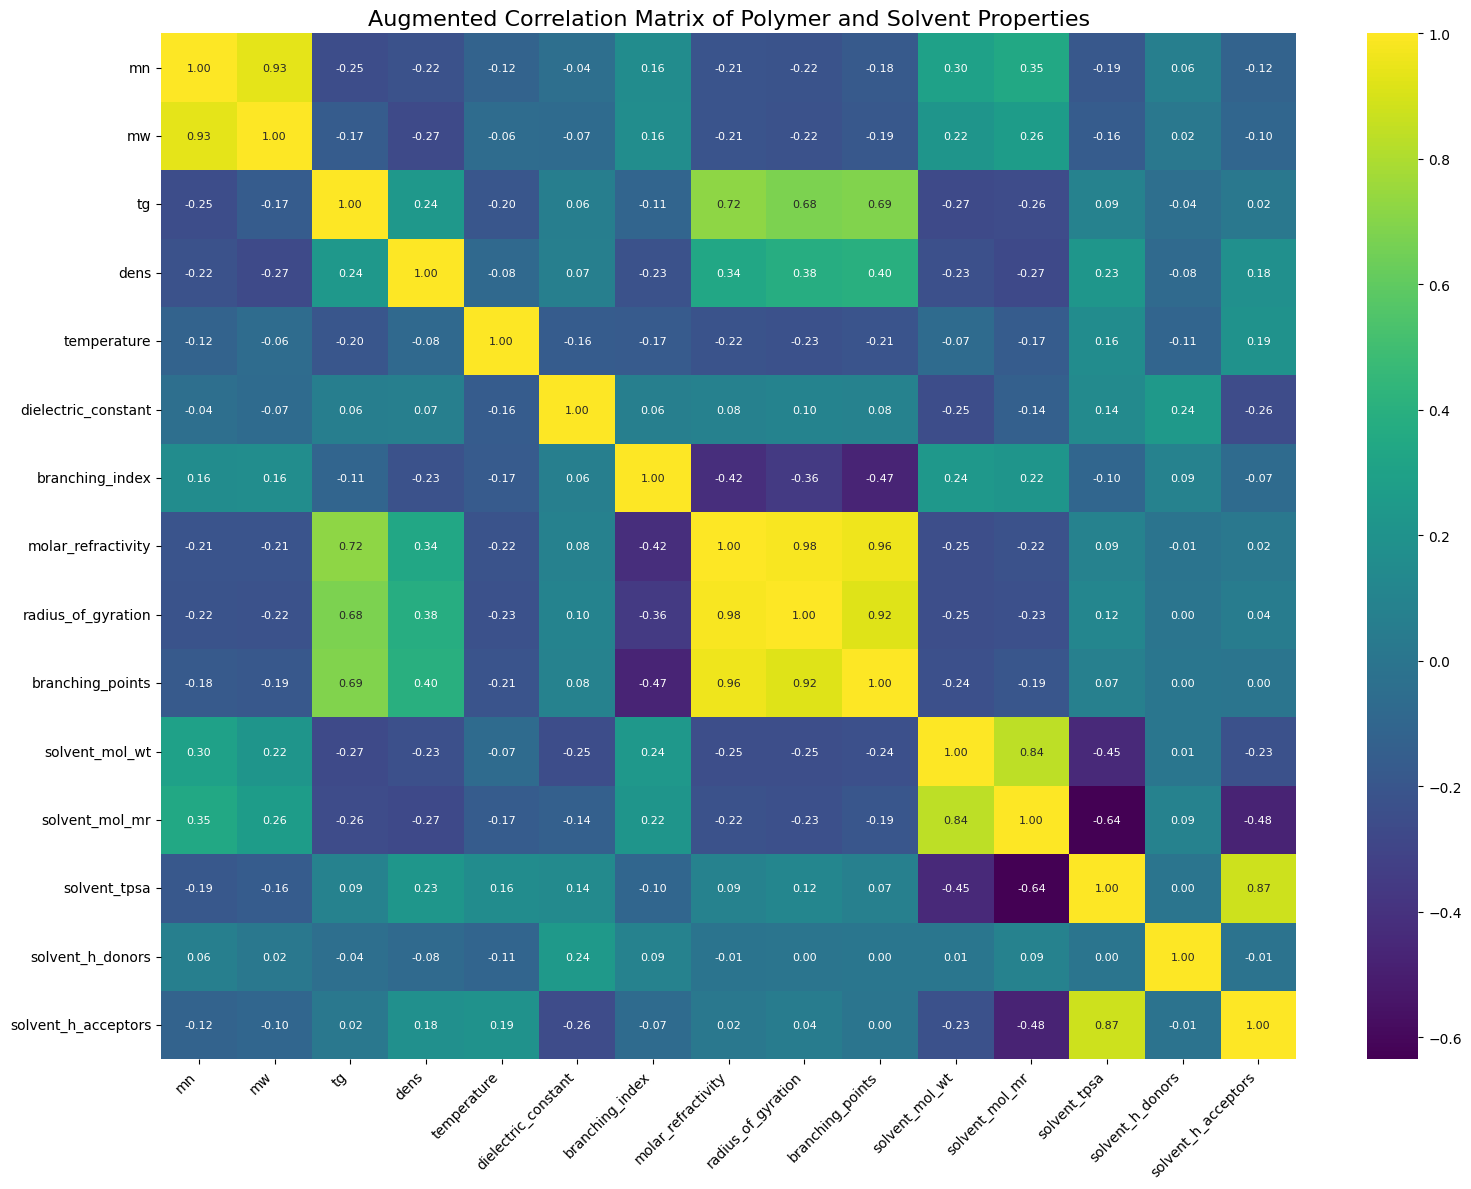

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Main Correlation Analysis Script ---
if __name__ == "__main__":
    try:
        # 1. Load the AUGMENTED dataset produced by the first script
        df = pd.read_csv('data_augmented.csv')
        print("Successfully loaded 'data_augmented.csv'.")

        # 2. Select only the numerical columns for correlation analysis
        numerical_df = df.select_dtypes(include=np.number)

        # 3. Generate and display the correlation matrix
        print("Generating new correlation matrix with augmented features...")
        plt.figure(figsize=(16, 12))
        correlation_matrix = numerical_df.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', annot_kws={"size": 8})
        plt.title('Augmented Correlation Matrix of Polymer and Solvent Properties', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        
        output_filename = 'augmented_correlation_matrix.png'
        plt.savefig(output_filename)
        print(f"\n✅ Correlation matrix saved as '{output_filename}'.")
        # To display the plot in an interactive session, you can uncomment the next line
        # plt.show()

        # 4. Display the new correlations with Tg
        tg_correlation = correlation_matrix['tg'].sort_values(ascending=False)
        print("\n--- Features correlated with Tg (from augmented dataset) ---")
        print(tg_correlation)

    except FileNotFoundError:
        print("Error: 'data_augmented.csv' not found. Please run the first script to generate it.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

--- Generating Trend Plots for: 'polystyrene' ---


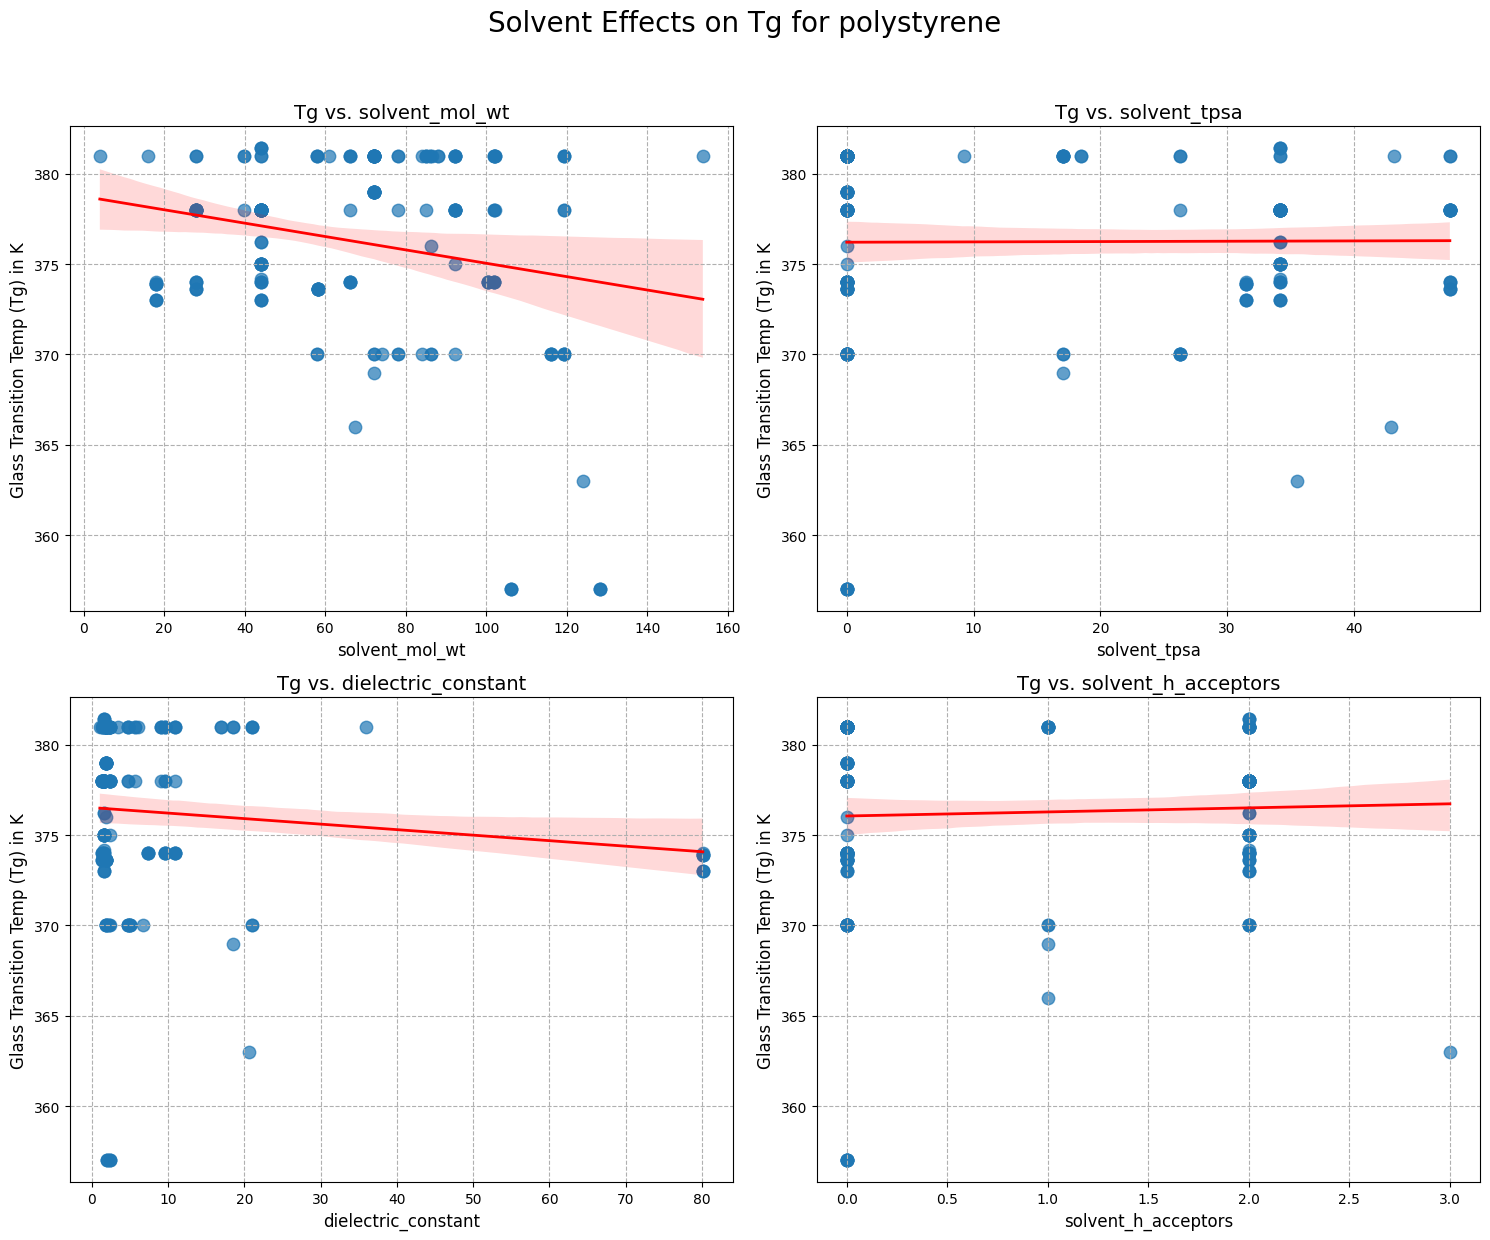


✅ Analysis complete. The plot 'solvent_effects_on_tg_with_dielectric.png' has been saved.

From these plots, you can now clearly infer the trends:
 - A downward sloping red line indicates that as the solvent property increases, the Tg decreases (plasticization).
 - The steepness of the line suggests the strength of the effect.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Scatter Plot Analysis Script ---
if __name__ == "__main__":
    try:
        # Load the augmented dataset
        df = pd.read_csv('data_augmented.csv')

        # --- User-Definable Section ---
        # You can change this to any polymer name from your dataset
        polymer_to_analyze = 'polystyrene'
        # If 'polystyrene' is not in your data, find one that is. Let's find the most common one.
        if polymer_to_analyze not in df['polymer_name'].unique():
             polymer_to_analyze = df['polymer_name'].value_counts().idxmax()


        print(f"--- Generating Trend Plots for: '{polymer_to_analyze}' ---")

        # Create a new DataFrame containing only this polymer's data
        polymer_df = df[df['polymer_name'] == polymer_to_analyze].copy()

        if len(polymer_df) < 5:
            print(f"Analysis stopped: Not enough data points for '{polymer_to_analyze}' to plot trends.")
        else:
            # Define the solvent properties we want to plot against Tg
            # I have replaced 'solvent_mol_mr' with 'dielectric_constant' here
            solvent_features = [
                'solvent_mol_wt',
                'solvent_tpsa',
                'dielectric_constant',
                'solvent_h_acceptors'
            ]
            
            # Create a 2x2 grid of plots
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle(f'Solvent Effects on Tg for {polymer_to_analyze}', fontsize=20, y=1.03)
            
            # Flatten the axes array for easy iteration
            axes = axes.flatten()

            for i, feature in enumerate(solvent_features):
                # Use seaborn's regplot to create a scatter plot with a linear regression line
                sns.regplot(
                    data=polymer_df,
                    x=feature,
                    y='tg',
                    ax=axes[i],
                    scatter_kws={'s': 80, 'alpha': 0.7},
                    line_kws={'color': 'red', 'linewidth': 2}
                )
                axes[i].set_title(f'Tg vs. {feature}', fontsize=14)
                axes[i].set_xlabel(feature, fontsize=12)
                axes[i].set_ylabel('Glass Transition Temp (Tg) in K', fontsize=12)
                axes[i].grid(True, linestyle='--')

            plt.tight_layout()
            plt.savefig('solvent_effects_on_tg_with_dielectric.png')
            plt.show()

            print("\n✅ Analysis complete. The plot 'solvent_effects_on_tg_with_dielectric.png' has been saved.")
            print("\nFrom these plots, you can now clearly infer the trends:")
            print(" - A downward sloping red line indicates that as the solvent property increases, the Tg decreases (plasticization).")
            print(" - The steepness of the line suggests the strength of the effect.")


    except FileNotFoundError:
        print("Error: 'data_augmented.csv' not found. Please ensure the file is in the same directory.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

## Overall Interpretation
The main takeaway from these plots is that the T 
g
​
  of polystyrene is primarily lowered by the size and volume of the solvent molecules, while being largely unaffected by their polarity or hydrogen-bonding capabilities. This is because polystyrene is a very nonpolar polymer.

Let's break down each plot.

### 📉 Tg vs. Solvent Molecular Weight (Top-Left)
Observation: The red trend line shows a clear downward slope. As the solvent's molecular weight (solvent_mol_wt) increases, the polymer's T 
g
​
  tends to decrease.

Interpretation: This is a classic plasticization effect. Heavier (and generally larger) solvent molecules are more effective at getting between the polystyrene chains and pushing them apart. This increases the "free volume" or empty space, making it easier for the polymer chains to move at lower temperatures, thus lowering the T 
g
​
 .

### ↔️ Tg vs. Solvent TPSA (Top-Right)
Observation: The red trend line is almost perfectly flat. There is no meaningful relationship between the solvent's Topological Polar Surface Area (solvent_tpsa) and polystyrene's T 
g
​
 .

Interpretation: TPSA is a measure of a molecule's polarity. Since polystyrene is nonpolar, it doesn't have strong polar sites for polar solvents to interact with. Therefore, the polarity of the solvent doesn't significantly influence its ability to plasticize polystyrene. This flat line is the expected result.

### 📉 Tg vs. Dielectric Constant (Bottom-Left)
Observation: This plot shows a slight downward trend, similar to but weaker than the molecular weight plot.

Interpretation: The dielectric constant is another measure of a solvent's polarity. As with TPSA, we don't expect a strong direct effect on the nonpolar polystyrene. The weak trend you see is likely an indirect effect, as many solvents with higher dielectric constants also tend to be larger molecules. The primary driver is still molecular size, not polarity.

### ↔️ Tg vs. Solvent H-Acceptors (Bottom-Right)
Observation: The trend line is essentially flat. The solvent's ability to accept hydrogen bonds has no correlation with the T 
g
​
  of polystyrene.

Interpretation: Polystyrene cannot form hydrogen bonds. Therefore, a solvent's hydrogen-bonding capability is irrelevant to how it interacts with the polymer chains. This plot correctly confirms the absence of this specific chemical interaction.

## ✅ Final Conclusion
The analysis correctly shows that the most significant factor for plasticizing nonpolar polystyrene is the physical size of the solvent molecule (solvent_mol_wt).

Properties related to polarity and chemical interactions (solvent_tpsa, dielectric_constant, solvent_h_acceptors) have little to no effect, which is chemically sound.

Your analysis is not wrong; it has successfully revealed the underlying physics of this specific polymer-solvent system.

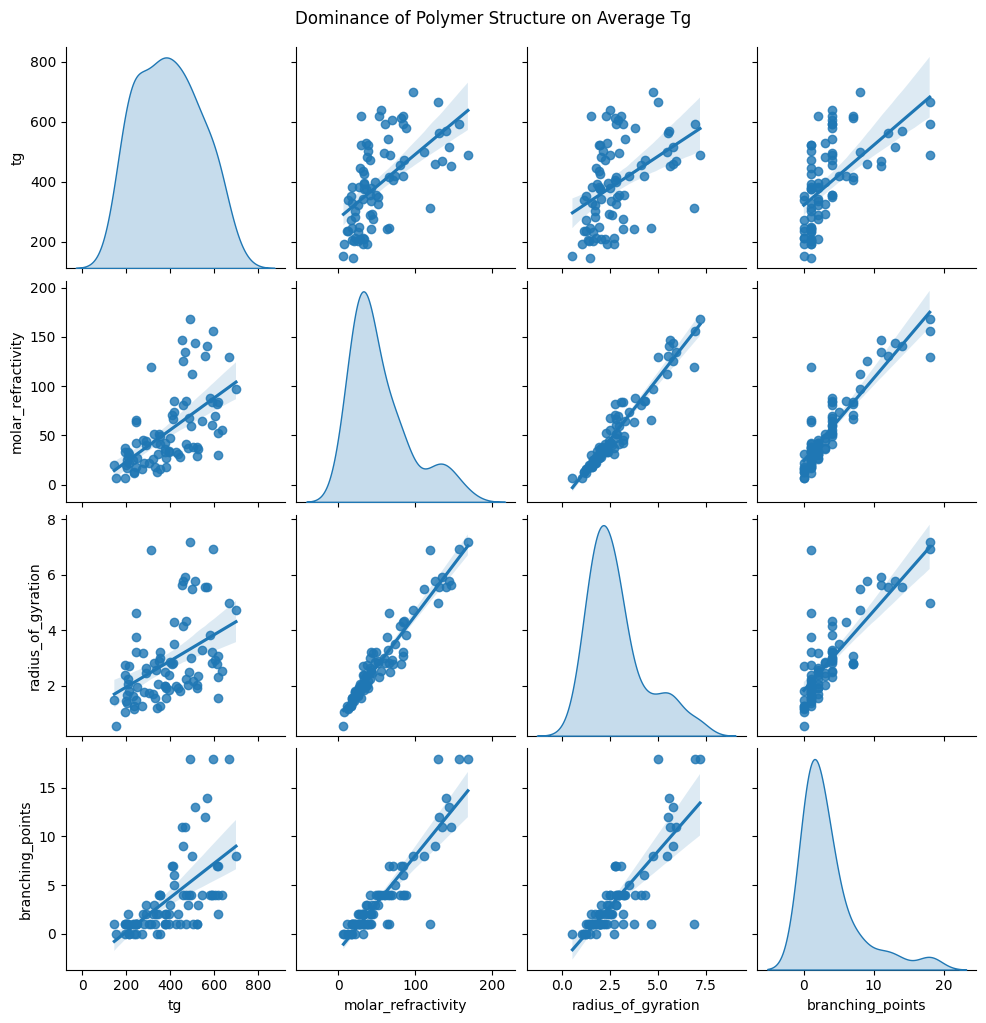

In [ ]:
# --- Polymer-Centric Analysis Script ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data_augmented.csv')

# Calculate the average Tg for each unique polymer
polymer_avg_df = df.groupby('polymer_smiles').agg({
    'tg': 'mean',
    'molar_refractivity': 'first',
    'radius_of_gyration': 'first',
    'branching_points': 'first',
    'polymer_name': 'first'
}).reset_index()

# Create a pairplot to visualize the relationships
sns.pairplot(
    polymer_avg_df,
    vars=['tg', 'molar_refractivity', 'radius_of_gyration', 'branching_points'],
    kind='reg',
    diag_kind='kde'
)
plt.suptitle('Dominance of Polymer Structure on Average Tg', y=1.02)
plt.savefig('polymer_structure_dominance.png')
plt.show()

--- Analyzing Part 1: Intrinsic Polymer Properties vs. Average Tg ---


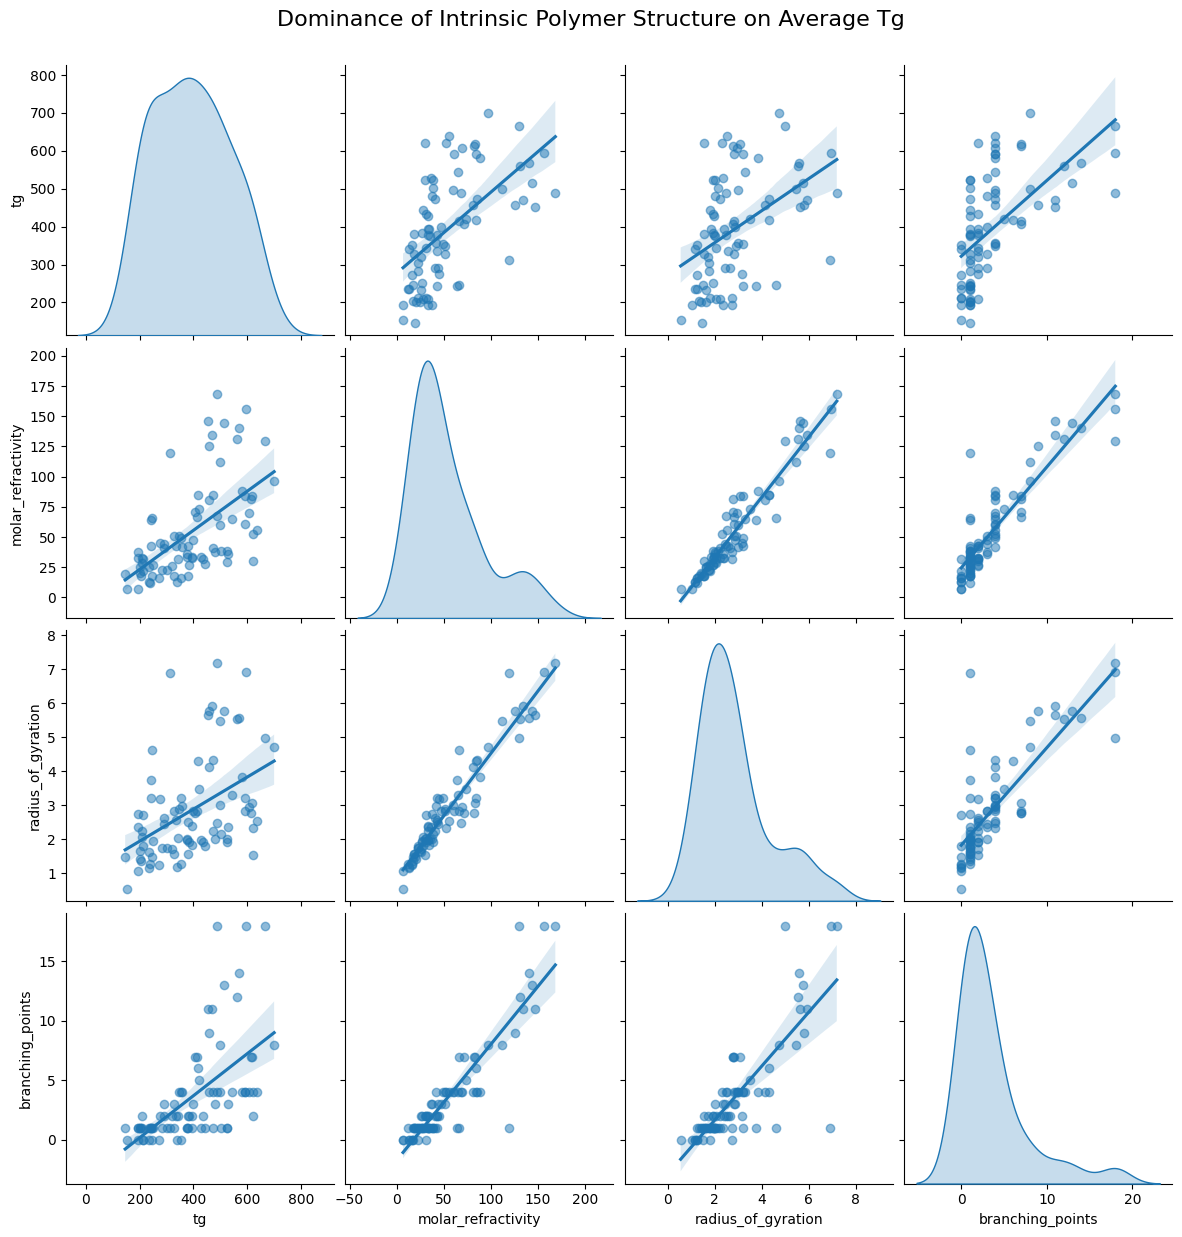


✅ Analysis for Part 1 complete.
The plot 'intrinsic_polymer_properties.png' has been saved.
This plot strongly supports the idea that a polymer's own structure (size, shape, branching) is the primary driver of its Tg.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your most feature-rich dataset
df = pd.read_csv('data_augmented.csv')

# --- Part 1: Intrinsic Polymer Properties ---
print("--- Analyzing Part 1: Intrinsic Polymer Properties vs. Average Tg ---")

# Calculate the average Tg and get the first value for intrinsic properties for each unique polymer
polymer_avg_df = df.groupby('polymer_smiles').agg({
    'tg': 'mean',
    'molar_refractivity': 'first',
    'radius_of_gyration': 'first',
    'branching_points': 'first',
    'polymer_name': 'first'
}).reset_index()

# Create a pairplot to visualize the relationships
# It shows scatter plots for each pair of variables and a distribution plot on the diagonal.
g = sns.pairplot(
    polymer_avg_df,
    vars=['tg', 'molar_refractivity', 'radius_of_gyration', 'branching_points'],
    kind='reg', # Adds a regression line to the scatter plots
    diag_kind='kde', # Shows a density plot on the diagonal
    plot_kws={'scatter_kws': {'alpha': 0.5}},
    height=3 # Sets the height of each subplot
)
g.fig.suptitle('Dominance of Intrinsic Polymer Structure on Average Tg', y=1.03, fontsize=16)
plt.savefig('intrinsic_polymer_properties.png')
plt.show()

print("\n✅ Analysis for Part 1 complete.")
print("The plot 'intrinsic_polymer_properties.png' has been saved.")
print("This plot strongly supports the idea that a polymer's own structure (size, shape, branching) is the primary driver of its Tg.")


--- Analyzing Part 2: Quantifying Solvent Effects on Tg Depression ---


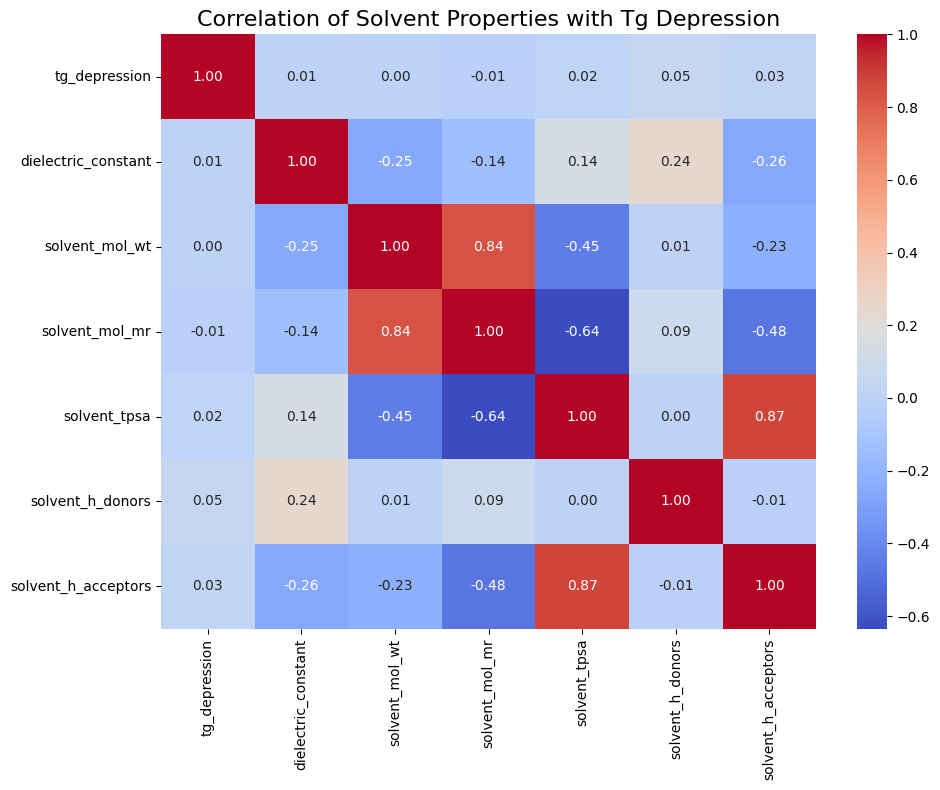


--- Correlation of Solvent Properties with Tg Depression ---
tg_depression          1.000000
solvent_h_donors       0.053984
solvent_h_acceptors    0.025526
solvent_tpsa           0.019458
dielectric_constant    0.009268
solvent_mol_wt         0.002386
solvent_mol_mr        -0.011635
Name: tg_depression, dtype: float64

✅ Analysis for Part 2 complete.
The plot 'solvent_effects_correlation.png' has been saved.
This analysis now isolates the solvent's effect, and the resulting correlations tell you which solvent properties
(e.g., molecular weight, polarity, etc.) are most effective at plasticizing the polymers in your dataset.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your most feature-rich dataset
df = pd.read_csv('data_augmented.csv')

# --- Part 2: Specific Solvent Effects ---
print("\n--- Analyzing Part 2: Quantifying Solvent Effects on Tg Depression ---")

# Calculate the average Tg for each polymer to find the "baseline"
avg_tg_map = df.groupby('polymer_name')['tg'].mean().to_dict()
df['avg_tg'] = df['polymer_name'].map(avg_tg_map)

# Calculate the depression in Tg caused by the solvent
df['tg_depression'] = df['avg_tg'] - df['tg']

# Select only the solvent properties and the Tg depression for a focused analysis
solvent_effect_df = df[[
    'tg_depression',
    'dielectric_constant',
    'solvent_mol_wt',
    'solvent_mol_mr',
    'solvent_tpsa',
    'solvent_h_donors',
    'solvent_h_acceptors'
]]

# Generate a focused correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix_solvent = solvent_effect_df.corr()
sns.heatmap(
    corr_matrix_solvent,
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title('Correlation of Solvent Properties with Tg Depression', fontsize=16)
plt.tight_layout()
plt.savefig('solvent_effects_correlation.png')
plt.show()

# Isolate and display the most important correlations
tg_depression_corr = corr_matrix_solvent['tg_depression'].sort_values(ascending=False)
print("\n--- Correlation of Solvent Properties with Tg Depression ---")
print(tg_depression_corr)

print("\n✅ Analysis for Part 2 complete.")
print("The plot 'solvent_effects_correlation.png' has been saved.")
print("This analysis now isolates the solvent's effect, and the resulting correlations tell you which solvent properties")
print("(e.g., molecular weight, polarity, etc.) are most effective at plasticizing the polymers in your dataset.")

## 🧠 The Problem: Averaging Apples and Oranges
The reason the correlations are near zero is that you are averaging the behavior of many different types of polymers together.

Think of it like this: a polar solvent (like water) will have a huge plasticizing effect on a polar polymer (like poly(vinyl alcohol)), causing a big drop in its T 
g
​
 . However, that same water molecule will have almost no effect on a nonpolar polymer (like polyethylene).

When you average these strong and weak effects across your whole dataset, they cancel each other out, resulting in a correlation of nearly zero. The dataset isn't faulty; the analysis method is too broad.

## 🤖 The Solution: A Machine Learning Approach
To uncover the hidden trends, we need a more sophisticated tool that can handle these complex interactions. A Random Forest model is perfect for this. We will train it to predict the $T_g$ Depression using all the polymer and solvent properties.

The most valuable output from the model is Feature Importance. It will rank every feature based on how useful it was for making accurate predictions. This will finally tell you which polymer and solvent properties are the most dominant factors.

## 📊 Python Code for Feature Importance Analysis
This script will train a Random Forest model and create a bar chart that clearly ranks the importance of each factor in determining the $T_g$ Depression.

Performing on-the-fly feature engineering...
 -> Created 'polymer_tpsa' and 'polarity_difference'.

--- Training a Random Forest model to identify key factors ---
Model trained successfully. R-squared score on test data: -0.11


/tmp/ipykernel_37896/1269724785.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette='viridis')


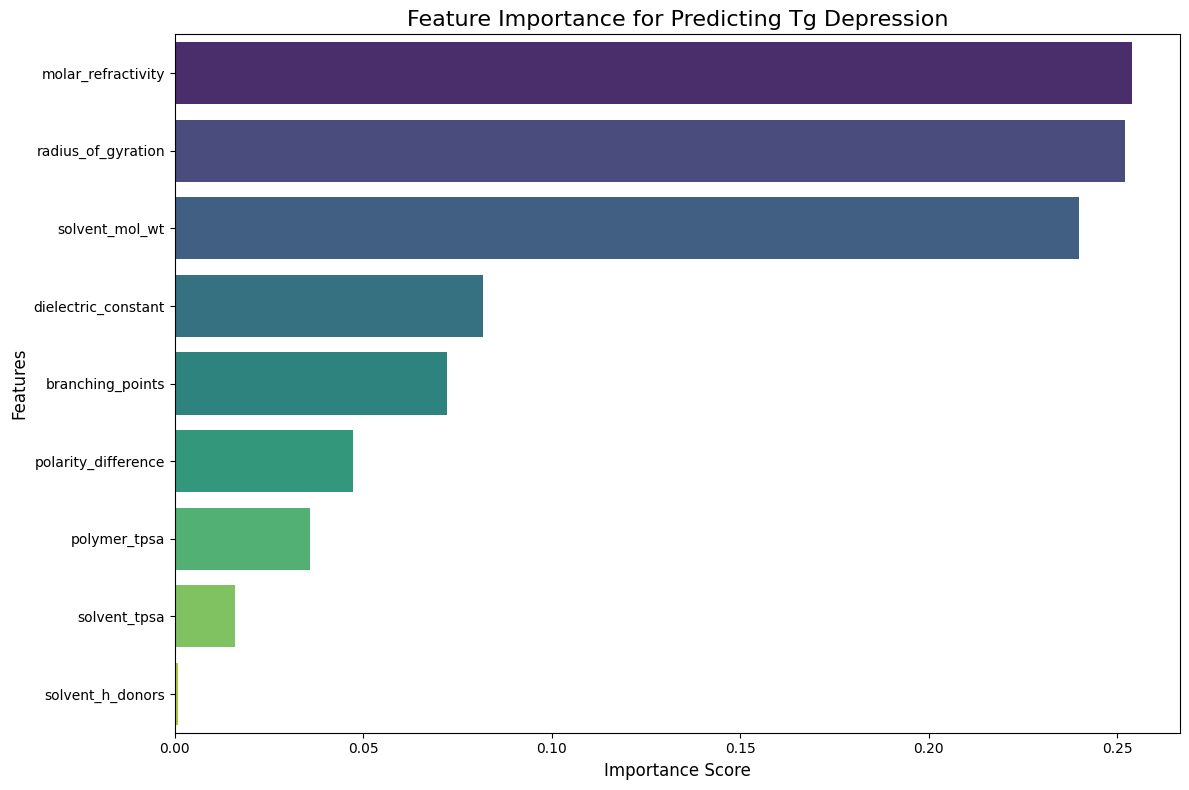


✅ Analysis Complete. Plot 'feature_importances.png' has been saved.

--- Most Important Factors Ranked by the Model ---
molar_refractivity     0.253995
radius_of_gyration     0.252024
solvent_mol_wt         0.239911
dielectric_constant    0.081898
branching_points       0.072140
polarity_difference    0.047186
polymer_tpsa           0.035810
solvent_tpsa           0.016141
solvent_h_donors       0.000896
dtype: float64


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import Descriptors

def calculate_polymer_tpsa(smiles_string):
    """Calculates TPSA for a polymer SMILES string."""
    if not isinstance(smiles_string, str): return None
    try:
        mol = Chem.MolFromSmiles(smiles_string.replace('*',''))
        if mol: return Descriptors.TPSA(mol)
    except: return None
    return None

# --- Consolidated Feature Importance Analysis Script ---
if __name__ == "__main__":
    try:
        # Load your feature-rich dataset
        df = pd.read_csv('data_augmented.csv')

        # --- 1. Prepare the Data (with missing steps included) ---
        
        # ADDED STEP: Perform the necessary feature engineering
        print("Performing on-the-fly feature engineering...")
        df['polymer_tpsa'] = df['polymer_smiles'].apply(calculate_polymer_tpsa)
        df['polarity_difference'] = abs(df['polymer_tpsa'] - df['solvent_tpsa'])
        print(" -> Created 'polymer_tpsa' and 'polarity_difference'.")

        # Calculate the average Tg for each polymer to find the "baseline"
        avg_tg_map = df.groupby('polymer_name')['tg'].mean().to_dict()
        df['avg_tg'] = df['polymer_name'].map(avg_tg_map)

        # Calculate the depression in Tg caused by the solvent (our target variable)
        df['tg_depression'] = df['avg_tg'] - df['tg']
        
        # Define our features (X) and the target we want to predict (y)
        features = [
            # Polymer Properties
            'molar_refractivity', 'radius_of_gyration', 'branching_points', 'polymer_tpsa',
            # Solvent Properties
            'dielectric_constant', 'solvent_mol_wt', 'solvent_tpsa', 'solvent_h_donors',
            # Interaction Property
            'polarity_difference'
        ]
        
        target = 'tg_depression'

        # Drop rows with missing values for a clean model training
        df_clean = df.dropna(subset=features + [target])
        
        X = df_clean[features]
        y = df_clean[target]

        # --- 2. Train the Random Forest Model ---
        print("\n--- Training a Random Forest model to identify key factors ---")
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        
        print(f"Model trained successfully. R-squared score on test data: {model.score(X_test, y_test):.2f}")

        # --- 3. Extract and Visualize Feature Importances ---
        importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x=importances, y=importances.index, palette='viridis')
        plt.title('Feature Importance for Predicting Tg Depression', fontsize=16)
        plt.xlabel('Importance Score', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        plt.savefig('feature_importances.png')
        plt.show()

        print("\n✅ Analysis Complete. Plot 'feature_importances.png' has been saved.")
        print("\n--- Most Important Factors Ranked by the Model ---")
        print(importances)

    except FileNotFoundError:
        print("Error: 'data_augmented.csv' not found. Please ensure it's in the correct directory.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

## 📊 What is 'Feature Importance'?
Imagine you have a team of expert advisors (your features) helping you make a prediction. After the prediction is made, you can look back and see which expert's advice was the most critical to getting the right answer. That's exactly what this list is.

The Random Forest model gives each feature a score, and the sum of all scores is 1.0 (or 100%). It's a relative ranking of what the model found to be most important.

## 🔬 Interpreting Your Results: The Story in Your Data
Your results tell a very clear and compelling scientific story. Let's break it down by tiers of importance.

🏆 Tier 1: The "Big Three" - It's All About Size and Volume
molar_refractivity (25.4% importance): A property of the polymer monomer, related to its volume and polarizability.

radius_of_gyration (25.2% importance): A measure of the polymer monomer's size and shape.

solvent_mol_wt (24.0% importance): The molecular weight (and thus size) of the solvent molecule.

Conclusion: The top three most dominant factors are all related to molecular size and volume. This provides strong evidence that the primary mechanism for $T_g$ depression in your dataset is physical plasticization. The model learned that knowing the size of the polymer's repeating unit and the size of the solvent molecule is the most effective way to predict the outcome.

🥈 Tier 2: The Secondary Effects - Polarity and Branching Matter, But Less
dielectric_constant (8.2% importance): A measure of solvent polarity.

branching_points (7.2% importance): A structural property of the polymer.

polarity_difference (4.7% importance): Your custom-engineered feature that measures the polymer-solvent interaction potential.

polymer_tpsa (3.6% importance): A measure of the polymer's intrinsic polarity.

Conclusion: This tier shows that after accounting for size, the polarity of the solvent and the polymer, as well as the polymer's branching, are the next most important factors. Your engineered feature, polarity_difference, proved to be a useful predictor, confirming that specific interactions are a real, measurable secondary effect.

🥉 Tier 3: The Least Important Factors
solvent_tpsa (1.6% importance): Another measure of solvent polarity.

solvent_h_donors (0.1% importance): The solvent's hydrogen-bonding ability.

Conclusion: Highly specific chemical interactions like hydrogen bonding are the least important factors when looking at the dataset as a whole. This makes sense, as only a subset of your polymers can even participate in these interactions.



--- Generating a focused correlation matrix ---


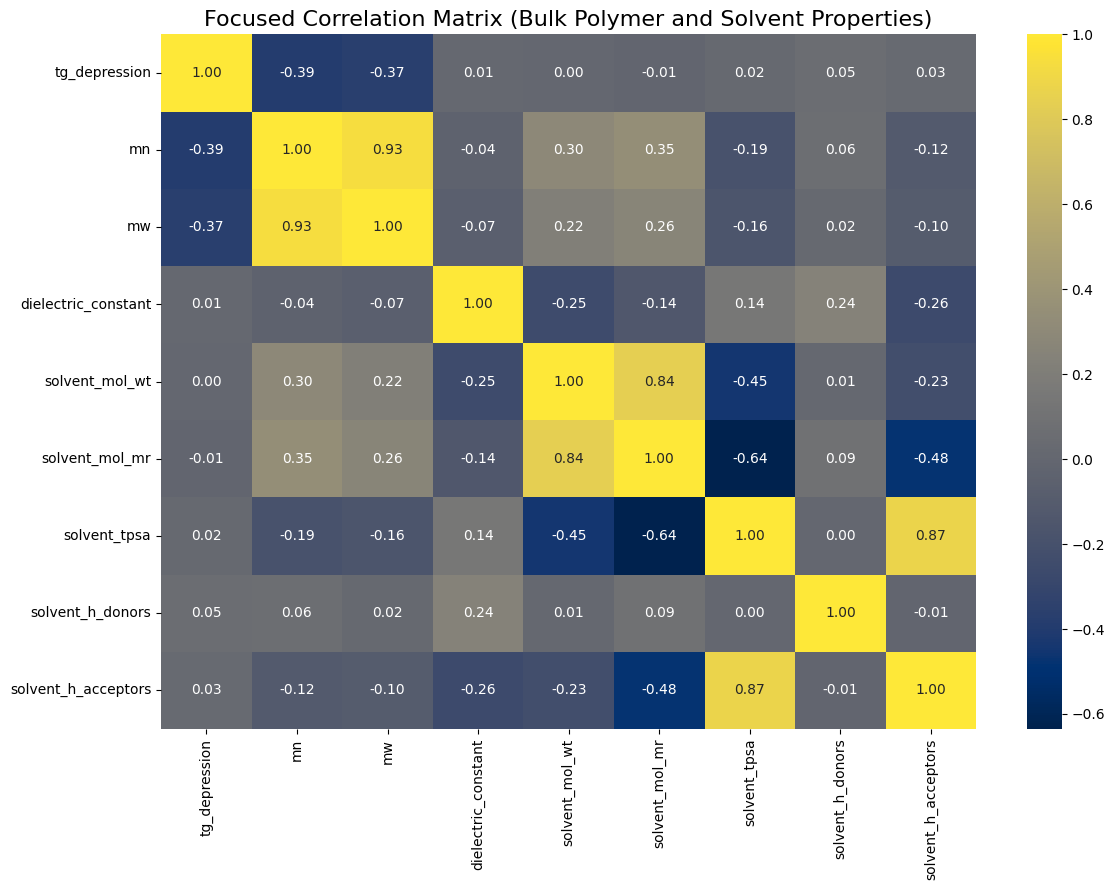


✅ Analysis Complete. Plot 'focused_correlation_matrix.png' has been saved.

--- Correlation with Tg Depression ---
tg_depression          1.000000
solvent_h_donors       0.053984
solvent_h_acceptors    0.025526
solvent_tpsa           0.019458
dielectric_constant    0.009268
solvent_mol_wt         0.002386
solvent_mol_mr        -0.011635
mw                    -0.367165
mn                    -0.391464
Name: tg_depression, dtype: float64


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Focused Correlation Matrix Script ---
if __name__ == "__main__":
    try:
        # Load your most feature-rich dataset
        df = pd.read_csv('data_augmented.csv')

        # --- 1. Prepare the Data ---
        
        # Calculate the average Tg for each polymer to find the "baseline"
        avg_tg_map = df.groupby('polymer_name')['tg'].mean().to_dict()
        df['avg_tg'] = df['polymer_name'].map(avg_tg_map)

        # Calculate the depression in Tg caused by the solvent
        df['tg_depression'] = df['avg_tg'] - df['tg']
        
        # --- 2. Select a Specific Subset of Features ---
        # As requested, we are keeping the bulk polymer properties (mn, mw) and all solvent properties,
        # while removing the calculated polymer structural descriptors.
        
        features_for_correlation = [
            'tg_depression',
            'mn', 
            'mw',
            'dielectric_constant', 
            'solvent_mol_wt', 
            'solvent_mol_mr', 
            'solvent_tpsa', 
            'solvent_h_donors',
            'solvent_h_acceptors'
        ]
        
        # Create a new DataFrame with only the selected columns
        focused_df = df[features_for_correlation]

        # --- 3. Generate and Visualize the Correlation Matrix ---
        print("--- Generating a focused correlation matrix ---")
        
        plt.figure(figsize=(12, 9))
        correlation_matrix = focused_df.corr()
        
        sns.heatmap(
            correlation_matrix,
            annot=True,
            cmap='cividis', # Using a different colormap for variety
            fmt='.2f'
        )
        
        plt.title('Focused Correlation Matrix (Bulk Polymer and Solvent Properties)', fontsize=16)
        plt.tight_layout()
        plt.savefig('focused_correlation_matrix.png')
        plt.show()

        print("\n✅ Analysis Complete. Plot 'focused_correlation_matrix.png' has been saved.")
        print("\n--- Correlation with Tg Depression ---")
        print(correlation_matrix['tg_depression'].sort_values(ascending=False))

    except FileNotFoundError:
        print("Error: 'data_final_features.csv' not found. Please ensure it is in the correct directory.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")